# [Virtual Epileptic Patient C++ implementation](https://github.com/Ziaeemehr/vbi_paper/blob/main/docs/examples/vep_sde.ipynb)

<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/vep_sde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tqdm
import torch
import pickle
import numpy as np
import networkx as nx
import sbi.utils as utils
from vbi import report_cfg
import matplotlib.pyplot as plt
from vbi.utils import LoadSample
from sbi.analysis import pairplot
from vbi.sbi_inference import Inference
from vbi.models.cpp.vep import VEP_sde
from sklearn.preprocessing import StandardScaler

In [2]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed);

In [3]:
os.makedirs("output/vep", exist_ok=True)

In [4]:
weights = np.loadtxt("data/weights1.txt")
nn = weights.shape[0]

healthy zone, propagation zone, epileptic zone eta values

In [5]:
hz_val = -3.65
pz_val = -2.4
ez_val = -1.6

In [6]:
ez_idx = np.array([6, 34], dtype=np.int32)
pz_wplng_idx = np.array([5, 11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [7]:
eta_true = np.ones(nn) * hz_val
eta_true[pz_idx] = pz_val
eta_true[ez_idx] = ez_val

In [8]:
initial_state = np.zeros(2 * nn)
initial_state[:nn] = -2.5
initial_state[nn:] = 3.5
# --------------------------------------------------------------------------- #

In [9]:
params = {
    "G": 1.0,
    "seed": seed,
    "initial_state": initial_state,
    "weights": weights,
    "tau": 10.0,
    "eta": -3.5,
    "noise_sigma": 0.0,
    "iext": 3.1,
    "dt": 0.1,
    "tend": 14.0,
    "tcut": 1.0,
    "noise_seed": 0,
    "record_step": 1,
    "method": "heun",
    "output": "output",
}

In [10]:
obj = VEP_sde(params)
g_true = 1.0
eta_true = [-1.6] * 2
eta_true_ = np.ones(nn) * hz_val
eta_true_[pz_idx] = pz_val
eta_true_[ez_idx] = ez_val
control_true = {"eta": eta_true_, "G": g_true}

In [11]:
data = obj.run(par=control_true)

In [12]:
ts = data["x"]
t = data["t"]

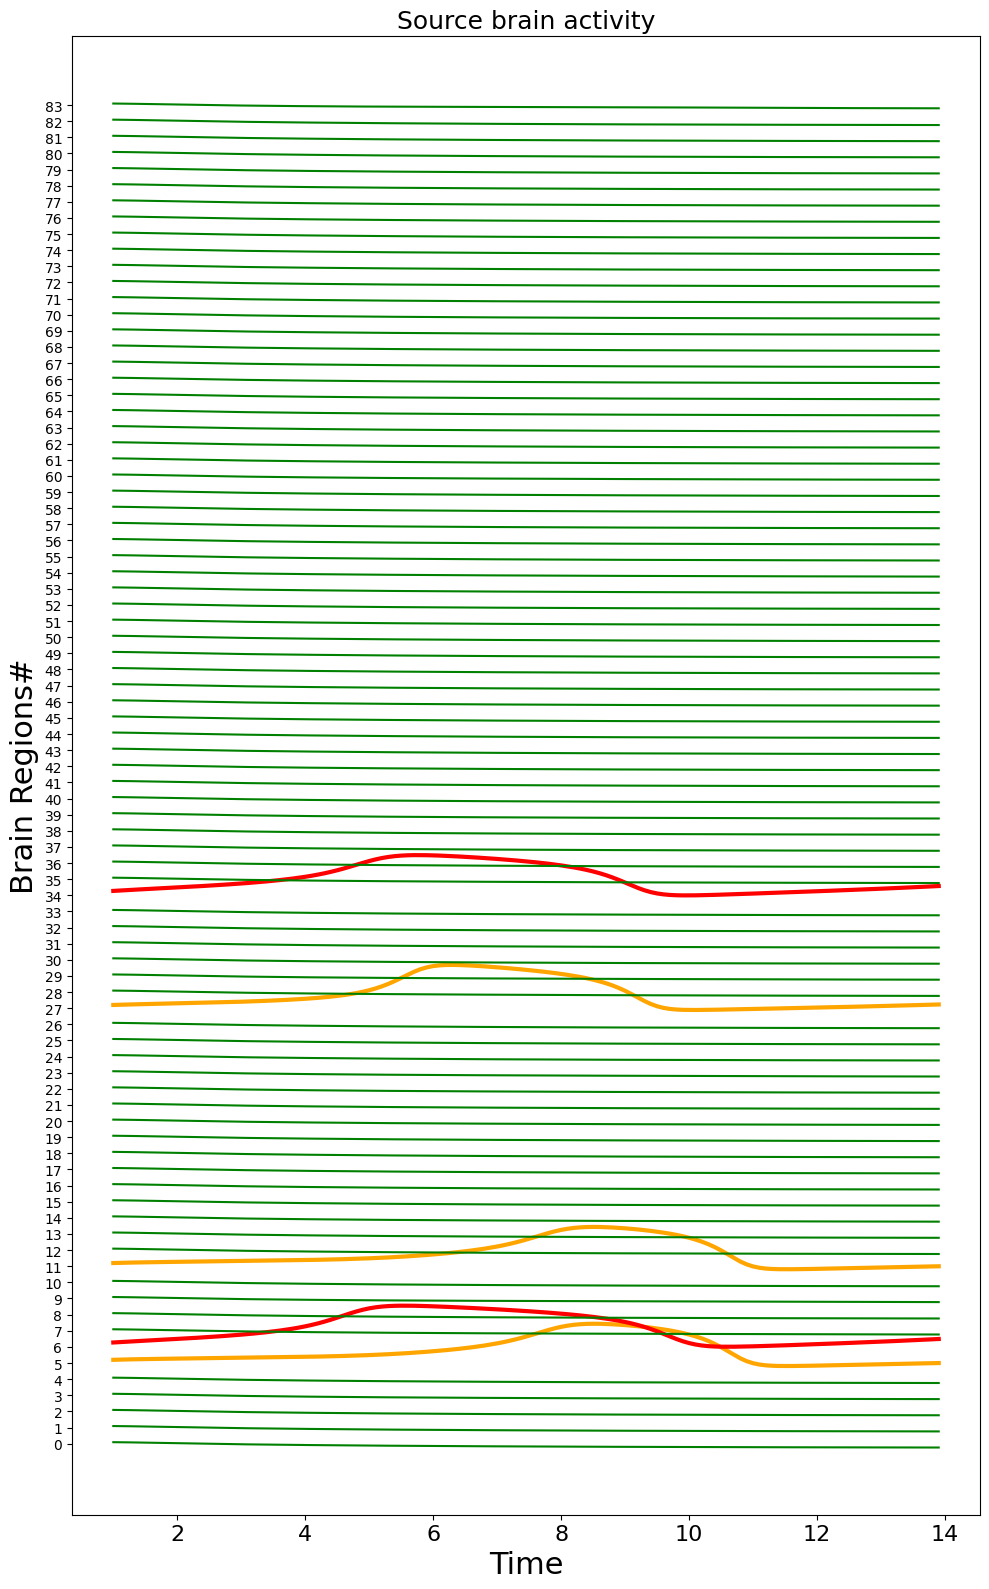

In [13]:

plt.figure(figsize=(10, 16))
for i in range(0, nn):
    if i in ez_idx:
        plt.plot(t, ts[i, :] + i, "r", lw=3)
    elif i in pz_idx:
        plt.plot(t, ts[i, :] + i, "orange", lw=3)
    else:
        plt.plot(t, ts[i, :] + i, "g")
plt.yticks(np.r_[0:nn] - 2, np.r_[0:nn], fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity", fontsize=18)
plt.xlabel("Time", fontsize=22)
plt.ylabel("Brain Regions#", fontsize=22)
plt.tight_layout()
# plt.savefig("output/vep_sde.png", dpi=300)

In [14]:
from vbi.feature_extraction.features_settings import *
from vbi.feature_extraction.calc_features import *

In [15]:
fs = 1 / (params["dt"]) / 1000
cfg = get_features_by_domain(domain="statistical")
# cfg = get_features_by_given_names(cfg, names=["calc_moments"])
cfg = get_features_by_given_names(cfg, names=["auc"])
# report_cfg(cfg)

In [16]:
data = extract_features_df([ts], fs, cfg=cfg, n_workers=1)
print(data.values.shape)

100%|██████████| 1/1 [00:00<00:00, 1240.55it/s]

(1, 84)


In [17]:
def wrapper(params, control, x0, cfg, verbose=False):
    vep_obj = VEP_sde(params)
    sol = vep_obj.run(control, x0=x0)

    # extract features
    fs = 1.0 / params["dt"] * 1000  # [Hz]
    stat_vec = extract_features(
        ts=[sol["x"]], cfg=cfg, fs=fs, n_workers=1, verbose=verbose
    ).values[0]
    return stat_vec

In [18]:
def batch_run(params, control_list, x0, cfg, n_workers=1):
    n = len(control_list)
    def update_bar(_):
        pbar.update()
    with Pool(processes=n_workers) as pool:
        with tqdm.tqdm(total=n) as pbar:
            async_results = [
                pool.apply_async(
                    wrapper,
                    args=(params, control_list[i], x0, cfg, False),
                    callback=update_bar,
                )
                for i in range(n)
            ]
            stat_vec = [res.get() for res in async_results]
    return stat_vec

In [19]:
num_sim = 1000
num_workers = 10
eta_min, eta_max = -5.0, -1.0
gmin, gmax = 0.0, 2.0

In [20]:
prior_min = [gmin] + [eta_min] * 2
prior_max = [gmax] + [eta_max] * 2

In [21]:
prior = utils.BoxUniform(low=torch.tensor(prior_min), high=torch.tensor(prior_max))

In [22]:
obj = Inference()
theta = obj.sample_prior(prior, num_sim)
theta_np = theta.numpy().astype(float)

In [23]:
print(theta_np.shape)

(1000, 3)


In [24]:
control_list = []
for i in range(num_sim):
    eta_ = np.ones(nn) * hz_val
    eta_[pz_idx] = pz_val
    eta_[ez_idx] = theta_np[i, 1:]
    g_ = theta_np[i, 0]
    control_list.append({"eta": eta_, "G": g_})

In [25]:
stat_vec = batch_run(params, control_list, initial_state, cfg, num_workers)

100%|██████████| 1000/1000 [00:01<00:00, 960.96it/s]


In [26]:
scalar = StandardScaler()
stat_vec_st = scalar.fit_transform(np.array(stat_vec))
stat_vec_st = torch.tensor(stat_vec_st, dtype=torch.float32)
torch.save(theta, "output/vep/theta.pt")
torch.save(stat_vec, "output/vep/stat_vec.pt")

In [27]:
print(theta.shape, stat_vec_st.shape)

torch.Size([1000, 3]) torch.Size([1000, 84])


In [28]:
posterior = obj.train(
    theta, stat_vec_st, prior, method="SNPE", density_estimator="maf", num_threads=8
)

 Neural network successfully converged after 355 epochs.train Done in 0 hours 0 minutes 26.661914 seconds


In [29]:
with open("output/vep/posterior.pkl", "wb") as f:
    pickle.dump(posterior, f)

In [30]:
with open("output/vep/posterior.pkl", "rb") as f:
    posterior = pickle.load(f)

In [31]:
xo = wrapper(params, control_true, initial_state, cfg)
xo_st = scalar.transform(xo.reshape(1, -1))

In [32]:
samples = obj.sample_posterior(xo_st, 10000, posterior)
# torch.save(samples, "output/vep/samples.pt")

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_1375221/387968677.py:3: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors', 'samples_colors', 'points_offdiag'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, ax = pairplot(


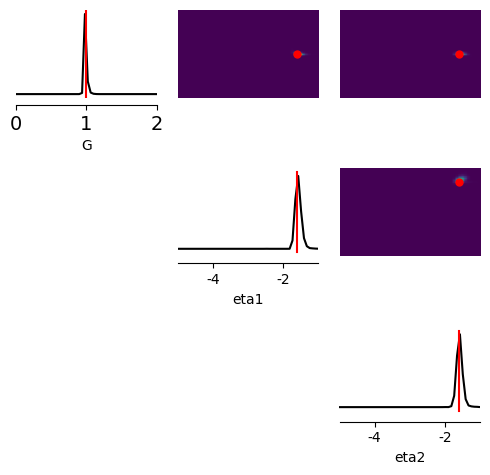

In [33]:
limits = [[i, j] for i, j in zip(prior_min, prior_max)]
points = [[g_true] + eta_true]
fig, ax = pairplot(
    samples,
    limits=limits,
    figsize=(5, 5),
    points=points,
    labels=["G", "eta1", "eta2"],
    offdiag="kde",
    diag="kde",
    points_colors="r",
    samples_colors="k",
    points_offdiag={"markersize": 10},
)
ax[0, 0].tick_params(labelsize=14)
ax[0, 0].margins(y=0)
plt.tight_layout();